In [85]:
from rouge import Rouge
from sklearn.metrics import classification_report, confusion_matrix
from zipfile import ZipFile
from tqdm import tqdm
import re, pandas as pd, numpy as np

In [69]:
train_pairs = pd.read_csv('train_pair_ids.tsv', sep='\t')
test_pairs = pd.read_csv('test_pair_ids.tsv', sep='\t')

## Rouge score for baseline

In [52]:
rouge = Rouge()

def eval_rouge(id1, id2):
    with ZipFile('aggr_texts.zip') as zf:
        names = zf.namelist()
        f1 = list(filter(lambda f: re.match(f'{id1}', f), names))
        f2 = list(filter(lambda f: re.match(f'{id2}', f), names))
        with zf.open(f1[0]) as f:
            text1 = f.read().decode()
        with zf.open(f2[0]) as f:
            text2 = f.read().decode()
        metrics = rouge.get_scores(text1, text2)
        return metrics

In [54]:
rougified = []
for d in tqdm(test_pairs.to_dict(orient='records')):
    d['rouge'] = eval_rouge(row['id1'], row['id2'])
    rougified.append(d)

100%|██████████| 70275/70275 [2:53:38<00:00,  6.75it/s]  


Use rouge for the longest similar sequences

In [64]:
rougified['rouge_l_f'] = rougified.rouge.apply(lambda r: r[0]['rouge-l']['f'])

In [68]:
rougified.rouge_l_f.max()

0.0

## Plan B: Tf-Idf

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier

Fit BoW on all texts

In [7]:
def text_generator():
    with ZipFile('aggr_texts.zip') as zf:
        names = zf.namelist()
        for fn in names:
            with zf.open(fn) as f:
                yield f.read().decode()

In [8]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3), min_df=0.01, max_df=0.97)
tfidf_vect.fit(text_generator())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.97, max_features=None, min_df=0.01,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
texts = np.array(list(text_generator()))
tfidf_vecs = tfidf_vect.transform(texts
                                 ).toarray()

In [36]:
with ZipFile('aggr_texts.zip') as zf:
    ids = list(map(lambda i: [re.sub('\D', '', i)], zf.namelist()))

ids = np.array(ids, dtype=int)

tfidf_vecs = np.hstack([ids, tfidf_vecs])

In [77]:
def tfidf_cosine_similarity(row):
    return cosine_similarity(tfidf_vecs[(tfidf_vecs[:, 0] == row.id1), 1:],
                             tfidf_vecs[(tfidf_vecs[:, 0] == row.id2), 1:])[0, 0]
test_pairs['similiarity'] = test_pairs.apply(tfidf_cosine_similarity, axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe72901a710>,
      dtype=object)

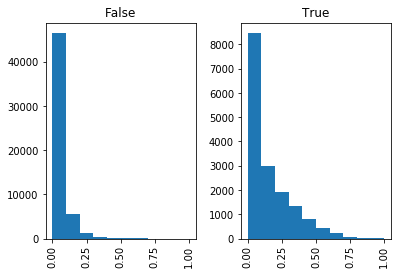

In [80]:
test_pairs.similiarity.hist(by=test_pairs.is_similar)

In [92]:
test_pairs['baseline_prediction'] = test_pairs.similiarity > 0.125

In [93]:
test_pairs.is_similar.value_counts()

False    53970
True     16305
Name: is_similar, dtype: int64

In [94]:
result = pd.concat([test_pairs.loc[test_pairs.is_similar, ],
                    test_pairs.loc[~test_pairs.is_similar, 
                                  ].sample(n=16305)])

In [95]:
print(classification_report(result.baseline_prediction, result.is_similar))

             precision    recall  f1-score   support

      False       0.91      0.61      0.73     24146
       True       0.43      0.82      0.56      8464

avg / total       0.78      0.67      0.69     32610



In [98]:
confusion_matrix(result.baseline_prediction, result.is_similar, labels=[True, False])

array([[ 6941,  1523],
       [ 9364, 14782]])

Baseline solution achieves 0.56% f1 score and detects less than a half of similar texts, despite also gives few false-positives